In [1]:
%matplotlib notebook
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func








In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [33]:
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lastdate)

('2017-08-23',)


In [34]:

# to get the last 12 months of data, last date - 365# to get 
year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year)

2016-08-23


In [35]:
# query to pull the last year of precipitation data
precep = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year).\
    order_by(Measurement.date).all()

In [36]:

# Load the data from the query into a dataframe# Load t 

precep1df = pd.DataFrame(precep)
precep1df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [37]:
#precepdf = precep1df.fillna(0)
#precepdf.head()
precepdf = precep1df.dropna()
precepdf.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


# Exploratory Climate Analysis

In [38]:
# Sort the dataframe by date
precepdf.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


<IPython.core.display.Javascript object>


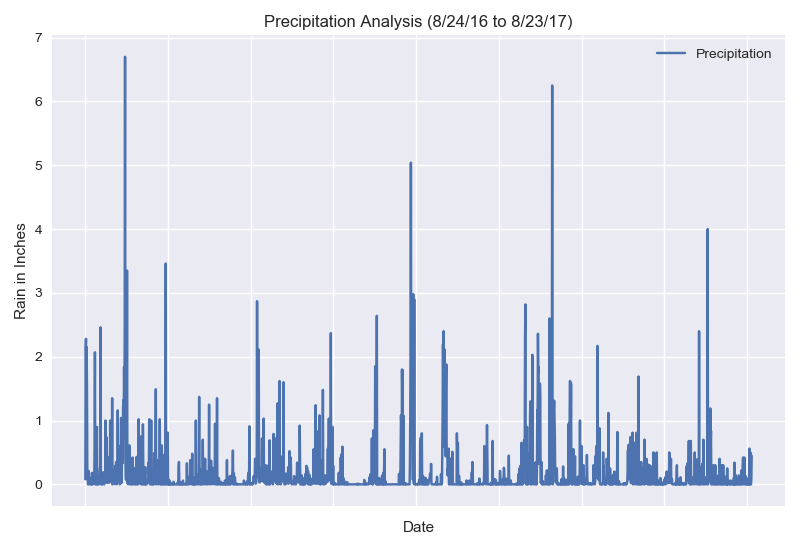

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
precepdf.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates


In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precepdf.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
mostactive = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
for station, count in mostactive:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [20]:
busiest = mostactive[0][0]
print(busiest)

USC00519281


In [21]:
temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > year).\
    order_by(Measurement.date).all()



In [22]:
tempdf = pd.DataFrame(temps)
tempdf.head()
min = tempdf.min()
max = tempdf.max()
avg = tempdf.mean()

In [23]:
tempdf.count()

date    351
tobs    351
dtype: int64

In [24]:
print(min, max, avg)

date    2016-08-24
tobs            59
dtype: object date    2017-08-18
tobs            83
dtype: object tobs    73.096866
dtype: float64


In [25]:
plt.hist(tempdf['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(busiest)
plt.tight_layout()
plt.show()

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrival = dt.date(2018, 8, 12)
leave = dt.date(2018, 8, 30)
lyear = dt.timedelta(days=365)
tempavg = (calc_temps((arrival-lyear), (leave-lyear)))
print(tempavg)

[(70.0, 78.72916666666667, 85.0)]


<IPython.core.display.Javascript object>


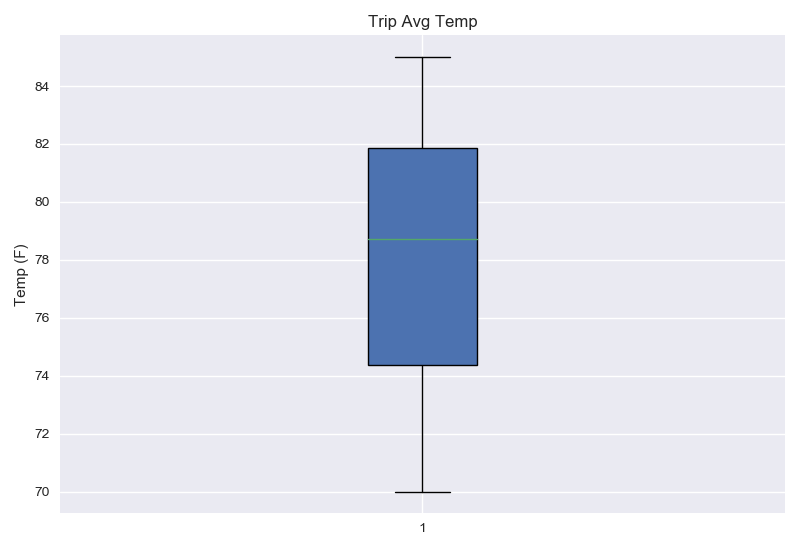

In [28]:
fig, ax = plt.subplots()
x = range(len(tempavg))
ax.boxplot(tempavg, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temp (F)")
fig.tight_layout()
plt.show()

In [57]:
lstarrive = arrival - lyear
lstleave = leave - lyear
print(lstarrive)
print(lstleave)

2017-08-12
2017-08-30


In [62]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
tripdata = session.query(Measurement.station, Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= lstarrive).\
    filter(Measurement.date <= lstleave).\
    order_by(Measurement.station).all()
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [63]:
tripdf=pd.DataFrame(tripdata)
tripdf.head()

,station,date,prcp
0,USC00514830,2017-08-13,NaN
1,USC00514830,2017-08-14,0.01
2,USC00514830,2017-08-15,0.00
3,USC00514830,2017-08-16,0.00
4,USC00514830,2017-08-17,0.00


In [64]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stationcsv = "resources/hawaii_stations.csv"
station = pd.read_csv(stationcsv)
station.head()


,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [65]:
mergestation = pd.merge(vacationdf, station, on="station")
mergestation.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00514830,2017-08-13,NaN,81.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
1,USC00514830,2017-08-14,0.01,81.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
2,USC00514830,2017-08-15,0.00,82.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00514830,2017-08-16,0.00,82.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
4,USC00514830,2017-08-17,0.00,78.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
